In [1]:
# THIS NOTEBOOK IS A DEAD END

import chainer
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import PIL
import tqdm
%matplotlib inline

In [2]:
chainer.cuda.get_device_from_id(0).use()

In [7]:
class CatDogResNet50(chainer.Chain):
    def __init__(self):
        super(CatDogResNet50, self).__init__()
        with self.init_scope():
            self.resnet50 = chainer.links.ResNet50Layers()
            self.fc_final = chainer.links.Linear(None, 2)
    def __call__(self, x):
        y = self.resnet50(x, layers=['pool5'])['pool5']
        return self.fc_final(y)

resnet = CatDogResNet50()
chainer.serializers.load_npz('result2/snapshot_iter_900', resnet)

KeyError: 'fc_final/b is not a file in the archive'

In [3]:
model = CatDogResNet50()
chainer.serializers.load_npz('model-210.npz', model)
model.to_gpu()

In [4]:
data = '../../data/kaggle/dogs-vs-cats-redux-kernels-edition/'
path_test = os.path.join(data, 'test')
test_images = os.listdir(path_test)
test_dataset = chainer.datasets.ImageDataset(test_images, root=path_test)

def Resize(size):
    def transform(image):
        label = None
        if len(image) == 2:
            image, label = image
        image = PIL.Image.fromarray(image.transpose(1, 2, 0).astype(np.uint8))
        image = image.resize(size, PIL.Image.NEAREST)
        if label is None:
            return np.asarray(image).transpose(2, 0, 1).astype(np.float32)
        else:
            return (np.asarray(image).transpose(2, 0, 1).astype(np.float32), label)
    return transform

test_dataset = chainer.datasets.TransformDataset(test_dataset, Resize((224, 224)))
test_dataset.test_images = test_images

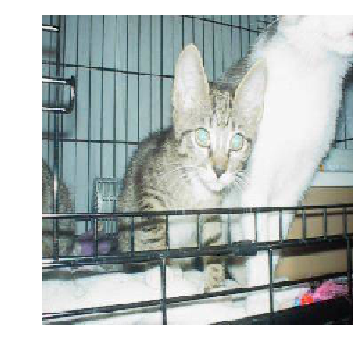

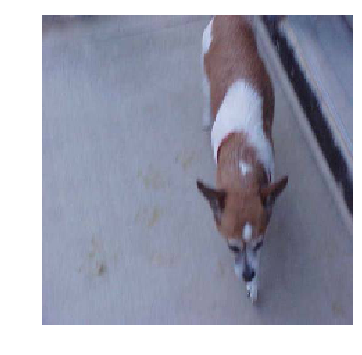

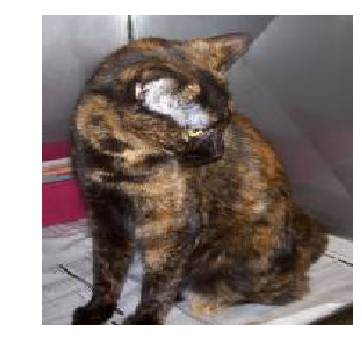

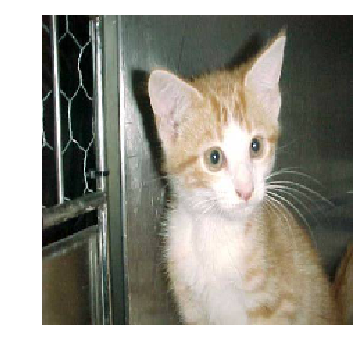

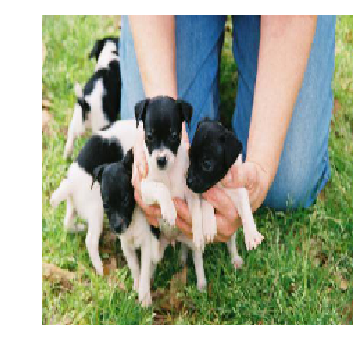

In [5]:
for i in range(5):
    image = test_dataset[i]
    image = np.transpose(image, (1, 2, 0)) / 255.
    plt.figure()
    plt.imshow(image, interpolation='nearest')
    plt.axis('off')
    #plt.title(string_of_label(label))

In [6]:
chainer.functions.softmax(model(model.xp.asarray(test_dataset[:5])))
# we have 0 = dog, 1 = cat here (opposite to what Kaggle expects)
# we want to produce P(dog)

variable([[  5.80212873e-05,   9.99941945e-01],
          [  9.98304248e-01,   1.69570546e-03],
          [  8.09549212e-01,   1.90450758e-01],
          [  6.92007643e-06,   9.99993086e-01],
          [  9.99841571e-01,   1.58428971e-04]])

In [7]:
probas = chainer.functions.softmax(model(model.xp.asarray(test_dataset[:10]))).data
proba_dog = probas[:, 0]
id_image = [int(os.path.splitext(x)[0]) for x in test_dataset.test_images][:len(proba_dog)]
prediction_small = pd.DataFrame(dict(id=id_image, label=list(proba_dog)))
prediction_small.sort_values('id', inplace=True)
prediction_small

,id,label
4,779,0.999598324299
9,1780,0.257380366325
6,2399,0.891654789448
5,2768,0.999978303909
3,4392,3.64405968867e-06
0,9292,6.55790427118e-05
2,9688,0.762698829174
8,10947,9.22561760319e-09
1,12026,0.968894720078
7,12225,0.999785602093


In [8]:
prediction_small.to_csv('prediction-small.csv', index=False)
!cat prediction-small.csv

id,label
779,0.999598324299
1780,0.257380366325
2399,0.891654789448
2768,0.999978303909
4392,3.64405968867e-06
9292,6.55790427118e-05
9688,0.762698829174
10947,9.22561760319e-09
12026,0.968894720078
12225,0.999785602093


In [20]:
# now let's create predictions for the complete test dataset, batch by batch
test_iter = chainer.iterators.SerialIterator(test_dataset, batch_size=128, repeat=False, shuffle=False)
probas = []
for batch in tqdm.tqdm(test_iter, total=len(test_dataset)/test_iter.batch_size):
    # .get() converts the GPU array to a CPU one
    proba_dog = chainer.functions.softmax(model(model.xp.asarray(batch))).data[:, 0].get()
    probas.append(proba_dog)
proba_dog = np.concatenate(probas)
id_image = [int(os.path.splitext(x)[0]) for x in test_dataset.test_images]
prediction = pd.DataFrame(dict(id=id_image, label=list(proba_dog)))
prediction.sort_values('id', inplace=True)
prediction

98it [02:17,  1.41s/it]                        


,id,label
7082,1,9.999969e-01
4067,2,1.000000e+00
3558,3,9.999895e-01
5730,4,9.998920e-01
2852,5,1.040396e-02
3896,6,4.967467e-01
9565,7,4.184139e-08
8351,8,1.440228e-02
9270,9,3.746670e-07
6412,10,4.972502e-05


In [22]:
prediction.to_csv('prediction.csv', index=False)
!cat prediction.csv

id,label
1,0.999996900558
2,1.0
3,0.999989509583
4,0.999891996384
5,0.0104039637372
6,0.496746718884
7,4.18413854675e-08
8,0.0144022814929
9,3.74666996095e-07
10,4.97250184708e-05
11,0.00229161977768
12,0.983979463577
13,1.90863579519e-06
14,0.00498283049092
15,1.964083296e-08
16,0.035122808069
17,0.998854517937
18,0.99998486042
19,9.80116965366e-06
20,0.0016705985181
21,1.0
22,0.0608002878726
23,0.999984622002
24,0.982105374336
25,2.6470692319e-05
26,0.905326545238
27,1.0
28,9.26769644138e-06
29,0.812953591347
30,0.996836543083
31,0.999999642372
32,0.419901788235
33,0.992805540562
34,0.0135933021083
35,0.021148217842
36,5.47798606476e-07
37,9.53956714511e-06
38,0.000383094855351
39,0.979126989841
40,0.000232293576119
41,0.999951124191
42,1.0
43,0.99997985363
44,0.886815071106
45,0.00124136579689
46,0.648185312748
47,0.000619584578089
48,0.999995350838
49,0.999944090843
50,0.844754040241
51,1.8188768081e-05
52,4.78351580568e-08
53,2.61456498265e-05
54,0.00020341144409
55,0.003321521449

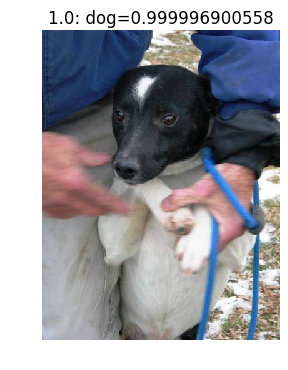

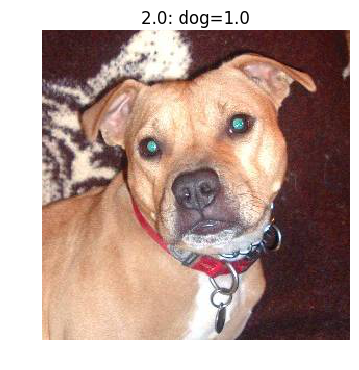

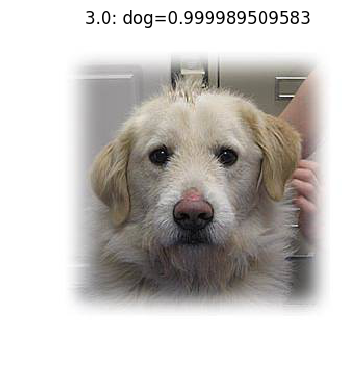

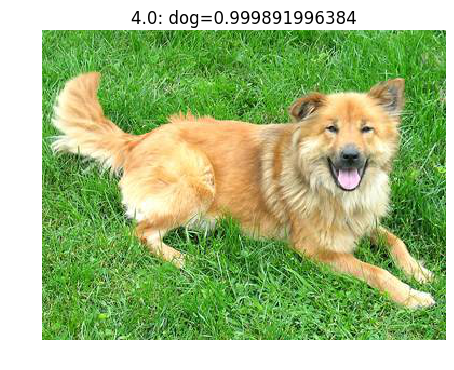

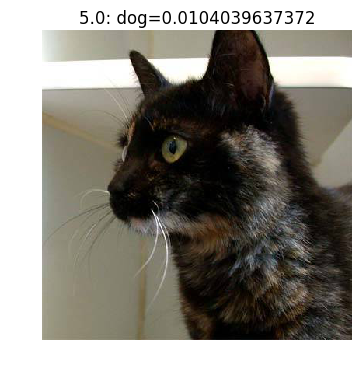

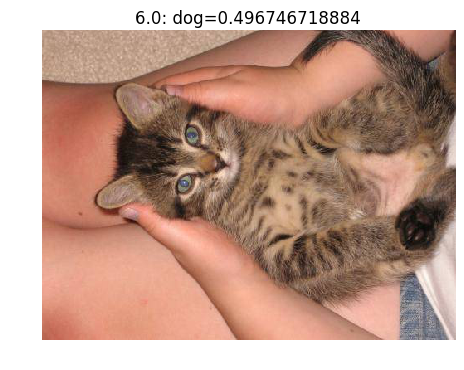

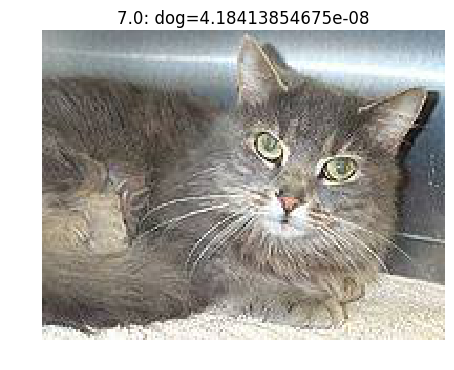

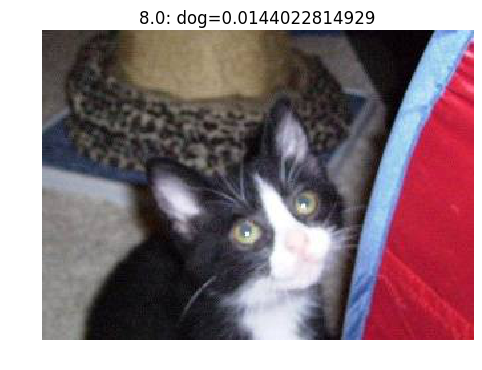

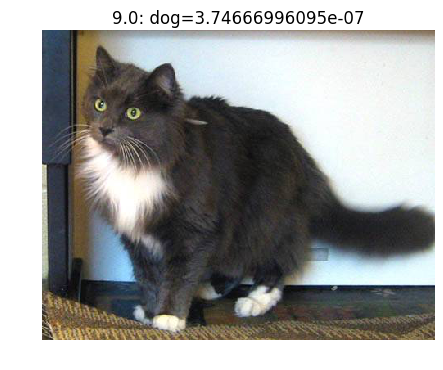

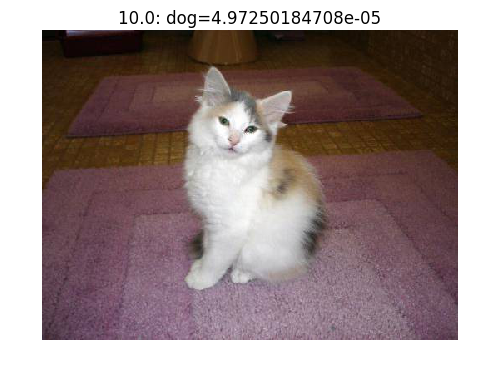

In [28]:
# check that our predictions are not absurd
for _, row in prediction[:10].iterrows():
    image = PIL.Image.open(os.path.join(data, 'test', "{}.jpg".format(int(row.id))))
    plt.figure()
    plt.imshow(image, interpolation='nearest')
    plt.axis('off')
    plt.title("{}: dog={}".format(row.id, row.label))

In [29]:
# !kg submit -m 'initial fast.ai submission (Chainer+ResNet50)' -c dogs-vs-cats-redux-kernels-edition -u ronanronan -p xxxx prediction.csv
# loss 0.17817 gives position 759/1314 = 57%
# target for position 50% (657) is 0.122

In [8]:
%debug

> /home/ubuntu/.local/lib/python2.7/site-packages/numpy/lib/npyio.py(237)__getitem__()
    235                 return self.zip.read(key)
    236         else:
--> 237             raise KeyError("%s is not a file in the archive" % key)
    238 
    239     def __iter__(self):

ipdb> l
    232                                          allow_pickle=self.allow_pickle,
    233                                          pickle_kwargs=self.pickle_kwargs)
    234             else:
    235                 return self.zip.read(key)
    236         else:
--> 237             raise KeyError("%s is not a file in the archive" % key)
    238 
    239     def __iter__(self):
    240         return iter(self.files)
    241 
    242     def items(self):

ipdb> l 225
    220         if key in self._files:
    221             member = 1
    222         elif key in self.files:
    223             member = 1
    224             key += '.npy'
    225         if member:
    226             bytes = self.zip.open(k